In [11]:
from scipy import signal
from scipy.spatial import distance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [12]:
#read in the data
EEG = pd.read_csv("C:/Users/danij/Documents/neuromove/IDUN_P300_test/10-9-Dani/eeg_data_007.csv", sep=',', header=None)
EEG = EEG.to_numpy(dtype=None, copy=False, na_value= float('nan'))
EEG = EEG.T
EEG_timestamp = EEG[1,:]

markers = pd.read_csv("C:/Users/danij/Documents/neuromove/IDUN_P300_test/10-9-Dani/marker_data_007.csv", sep=',', header=None)
markers = markers.to_numpy(dtype=None, copy=False, na_value= float('nan'))
markers = markers.T
markers_timestamp = markers[1,:]
markers_data = markers[0,:]

In [13]:
# notch filter to remove powerline noise
notch_freq = 60 
numerator, denominator = signal.iirnotch(notch_freq, 20, 250)
filtered_notch_data = signal.filtfilt(b=numerator, a=denominator, x=EEG, padtype=None)

# bandpass filter to remove common artefacts during resting state recordings

high_pass_freq = 1
low_pass_freq = 8
denom, nom = signal.iirfilter(int(3), [high_pass_freq, low_pass_freq], btype="bandpass", ftype="butter", fs=float(250), output="ba")
filtered_bp_data = signal.filtfilt(b=denom, a=nom, x=filtered_notch_data, padtype=None)


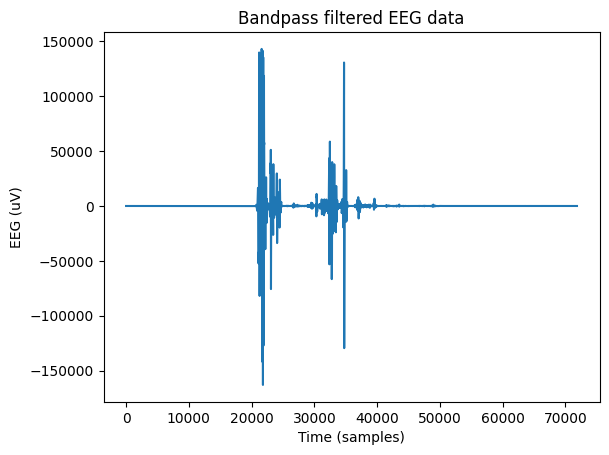

In [15]:

plt.figure()
plt.plot(filtered_bp_data[0,:])
plt.xlabel("Time (samples)")
plt.ylabel("EEG (" + "uV" + ")")
plt.title("Bandpass filtered EEG data")
plt.show()

In [ ]:
EEG_marked = np.zeros((3, len(EEG_timestamp)))
EEG_marked[0, :] = filtered_bp_data[0,:] #EEG Data
EEG_marked[1, :] = filtered_bp_data[1,:] #EEG Timestamps


P300_timestamps = []

for i in range(len(markers_timestamp)):
    if markers_data[i] == [2]:
        P300_timestamps.append(markers_timestamp[i])

epochs = []

for P300_time in P300_timestamps:
    distances = np.abs(EEG_timestamp - P300_time)
    closest_index = np.argmin(distances)
    EEG_marked[
        
        
        
        2, closest_index] = 1

In [7]:
print((P300_timestamps))
print(sum(EEG_marked[2,:]))


[1745728927.350373, 1743428316.969463, 1740360836.461584, 1739338342.9589574, 1735503992.324108, 1734225875.4458249, 1730647148.1866322, 1727579667.678753, 1726301550.8004696, 1722722823.541277, 1721444706.662994, 1719144096.2820842, 1715054122.2715783, 1713520382.0176384, 1709686031.3827891, 1708152291.1288495, 1704317940.4940002, 1702017330.1130905, 1700739213.2348075, 1697416109.3512714]
1.0


In [8]:
#Epoching
fs = 250
samples_per_ms = fs/1000
pre_mark_ms = 100
post_mark_ms = 500

pre_event_samples = int(pre_mark_ms * samples_per_ms)
post_event_samples = int(post_mark_ms * samples_per_ms)

# Find indices of event markers
event_indices = np.where(EEG_marked[2, :] == 1)[0]
print(event_indices)
epochs = []

for event_index in event_indices:
    # Calculate the start and end indices for the epoch
    start_index = max(0, event_index - pre_event_samples)
    end_index = min(EEG_marked.shape[1], event_index + post_event_samples + 1)
    
    # Extract the epoch data
    epoch = EEG_marked[:, start_index:end_index]
    epochs.append(epoch)

# Convert list of epochs to a NumPy array (optional)
epochs = np.array(epochs)
print(np.shape(epochs))

[95560]
(1, 3, 26)


In [180]:
bad_epochs = [6,19,24]
cut_epochs = np.delete(epochs, bad_epochs, axis=0)
print(cut_epochs.shape)
epochs = cut_epochs 

(25, 3, 151)


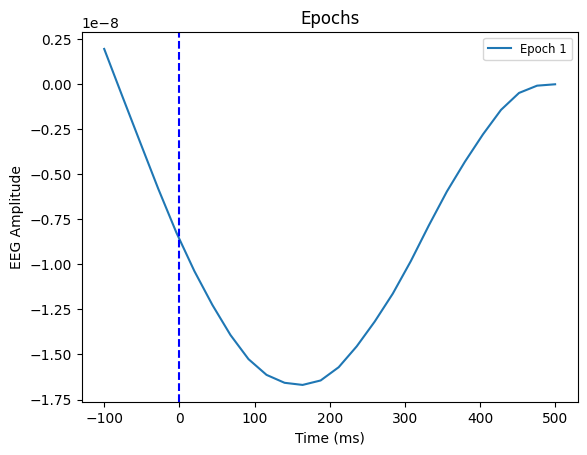

In [9]:
samples = epochs.shape[2]
time = np.linspace(-100, 500, samples)

plt.figure()
for i in range(epochs.shape[0]): #epochs.shape[0] #6,19,14/24
    plt.plot(time, epochs[i,0,:], label=f'Epoch {i+1}')
plt.xlabel("Time (ms)")
plt.ylabel("EEG Amplitude")
plt.title("Epochs")
plt.legend(loc='upper right', fontsize='small')
plt.axvline(x=0, color='blue', linestyle='--', linewidth=1.5, label='Event Onset')
plt.show()

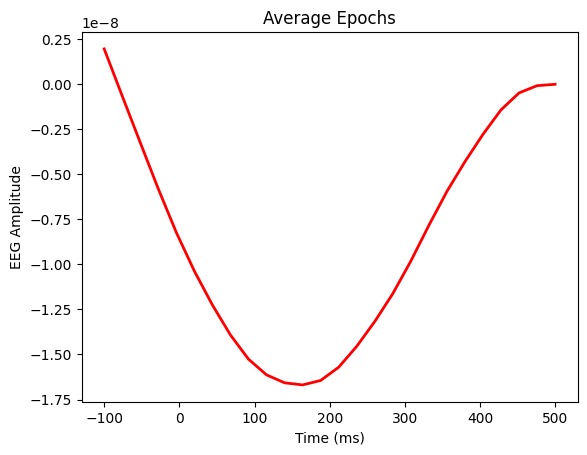

In [10]:
average_epoch = np.mean(epochs[:,0,:], axis=0)

plt.figure()
plt.plot(time, average_epoch, color='red', linewidth=2, label='Average Epoch')
plt.xlabel("Time (ms)")
plt.ylabel("EEG Amplitude")
plt.title("Average Epochs")
plt.show()
